In [44]:
from typing import Callable, Any
from functools import partial

import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import optax
import jaxopt
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock
from typing import Callable, List, Tuple

# Ensure reproducibility
rng = jax.random.PRNGKey(0)
print('CUDA?', jax.devices(), jax.devices()[0].device_kind)

CUDA? [CpuDevice(id=0)] cpu


In [45]:
print('JAX devices:', jax.devices())

JAX devices: [CpuDevice(id=0)]


In [46]:
# Test-configuration
dataset_size = 128
test_resolution = 512

# Train-configuration
num_posterior_mc = 1  # number of latents to sample from p(Z | X, Y)
batch_size = 128  # number of functions to sample from p(Z)
kl_penalty = 1e-4  # Magnitude of the KL-divergence in the loss
num_target_samples = 32
num_context_samples = 64

In [47]:
f1 = Fourier(n=4, amplitude=.5, period=1.0)
f2 = Fourier(n=2, amplitude=.5, period=1.0)
f3 = Fourier(n=6, amplitude=3, period=2.0)
f4 = Fourier(n=3, amplitude=1.0, period=2.0)

m = Mixture([Shift(f1, y_shift=-2), Shift(f2, y_shift=0.0), Shift(f3, y_shift=2)])
nm = Mixture([WhiteNoise(m.branches[0], 0.05), WhiteNoise(m.branches[1], 0.2), WhiteNoise(m.branches[2], 0.1)])

rng = jax.random.PRNGKey(0)


In [48]:
def joint(
    module: nn.Module, 
    data_sampler: Callable[[nn.Module, flax.typing.VariableDict, flax.typing.PRNGKey], tuple[jax.Array, jax.Array]],
    key: flax.typing.PRNGKey, 
    return_params: bool = False
) -> tuple[jax.Array, jax.Array]:
    key_param, key_rng, key_data = jax.random.split(key, 3)
    params = module.init({'param': key_param, 'default': key_rng}, jnp.zeros(()))
    xs, ys = data_sampler(module, params, key_data)
    if return_params:
        return xs, ys, params
    return xs, ys

def uniform(
    module: nn.Module, 
    params: flax.typing.VariableDict, 
    key: flax.typing.PRNGKey, 
    n: int,
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:
    key_xs, key_ys = jax.random.split(key)
    xs = jax.random.uniform(key_xs, (n,)) * (bounds[1] - bounds[0]) + bounds[0]
    ys = jax.vmap(module.apply, in_axes=(None, 0))(params, xs, rngs={'default': jax.random.split(key_ys, n)})
    return xs, ys

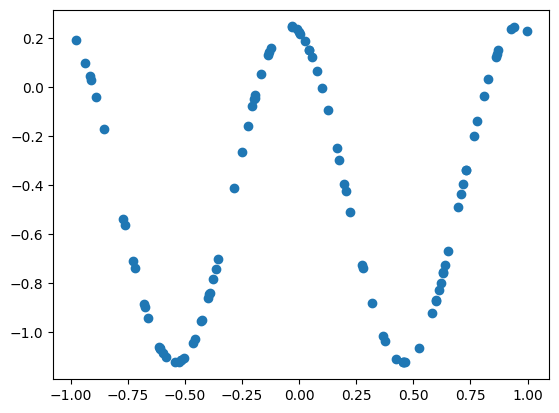

In [49]:
rng, key = jax.random.split(rng)
sampler_clean = partial(joint, f2, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
x, y = sampler_clean(key)
#x, y = [..., None], [..., None]
plt.scatter(x, y)

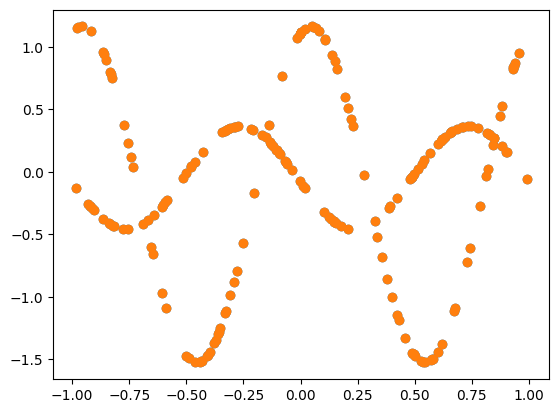

In [50]:
outtask_x_eval, outtask_y_eval = jax.vmap(sampler_clean)(jax.random.split(rng, 2))
#outtask_x_eval, outtask_y_eval = outtask_x_eval[..., None], outtask_y_eval[..., None]
for i in range(outtask_x_eval.shape[0]):
    plt.scatter(outtask_x_eval, outtask_y_eval)

In [51]:
class Fourier_range(nn.Module):
    n_range: Tuple[int, int]
    period_range: Tuple[float, float]
    amplitude_range: Tuple[float, float]
    phase_range: Tuple[float, float]

    def setup(self):
        self.n = self.param(
            'n', 
            lambda rng, shape: jax.random.randint(rng, shape, self.n_range[0], self.n_range[1] + 1), 
            ()
        ).item()
        
        self.period = self.param(
            'period', 
            nn.initializers.uniform(scale=self.period_range[1] - self.period_range[0]), 
            ()
        ) + self.period_range[0]

        self.amplitude = self.param(
            'amplitude', 
            nn.initializers.uniform(scale=self.amplitude_range[1] - self.amplitude_range[0]), 
            (self.n,)
        ) + self.amplitude_range[0]
        
        self.phase = self.param(
            'phase', 
            nn.initializers.uniform(scale=self.phase_range[1] - self.phase_range[0]), 
            (self.n - 1,)
        ) + self.phase_range[0]


    @nn.compact
    def __call__(self, x: jax.typing.ArrayLike) -> jax.Array:
        shift = self.param(
            'shift',
            nn.initializers.uniform(scale=jnp.pi),
            jnp.shape(x), x.dtype
        )

        x = x - shift
        amplitude = self.amplitude * jnp.arange(1, len(self.amplitude) + 1) / (self.n - 1)
        waves = jnp.cos(
            (2 * jnp.pi * jnp.arange(1, self.n) * x - self.phase) / self.period
        )

        return amplitude[0] / 2.0 + jnp.sum(amplitude[1:] * waves, axis=0)

In [52]:
class Fourier_range(nn.Module):
    n_range: Tuple[int, int]
    period_range: Tuple[float, float]
    amplitude_range: Tuple[float, float]
    phase_range: Tuple[float, float]

    def generate_params(self):
        key = self.make_rng('params')
        keys = jax.random.split(key, 4)
        
        n = jax.random.randint(keys[0], (), self.n_range[0], self.n_range[1] + 1)
        period = jax.random.uniform(keys[1], (), minval=self.period_range[0], maxval=self.period_range[1])
        amplitude = jax.random.uniform(keys[2], (n,), minval=self.amplitude_range[0], maxval=self.amplitude_range[1])
        phase = jax.random.uniform(keys[3], (n - 1,), minval=self.phase_range[0], maxval=self.phase_range[1])
        
        return n, period, amplitude, phase

    @nn.compact
    def __call__(self, x: jax.typing.ArrayLike) -> jax.Array:
        n, period, amplitude, phase = self.generate_params()

        # Initialize shift
        shift = self.param(
            'shift',
            nn.initializers.uniform(scale=jnp.pi),
            jnp.shape(x), x.dtype
        )

        x = x - shift
        amplitude = amplitude * jnp.arange(1, n + 1) / (n - 1)
        waves = jnp.cos(
            (2 * jnp.pi * jnp.arange(1, n) * x - phase) / period
        )

        return amplitude[0] / 2.0 + jnp.sum(amplitude[1:] * waves, axis=0)


In [55]:
#data_sampler = partial(joint, f2, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
fourier_instance_range = Fourier_range(
    n_range=[2, 6],
    period_range=[0.5, 2.0],
    amplitude_range=[1, 2.0],
    phase_range=[0.0, jnp.pi]
)


#data_sampler_nr = partial(joint, f_nr1, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
data_sampler_range = data_sampler = partial(joint, fourier_instance_range, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))

In [56]:
# fourier_instance_range = Fourier_range(
#     n_range=[2, 6],
#     period_range=[0.5, 2.0],
#     amplitude_range=[1, 2.0],
#     phase_range=[0.0, jnp.pi]
# )


# #data_sampler_nr = partial(joint, f_nr1, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
# data_sampler_range = partial(joint, fourier_instance_range, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
rng, key = jax.random.split(rng)
x, y = data_sampler(key)
plt.scatter(x, y)

TypeError: Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = Array([2, 6, 5, 5, 4, 5, 5, 3, 3, 4, 2, 5, 2, 5, 5, 2, 4, 2, 2, 4, 6, 5,
       3, 3, 2, 3, 5, 2, 4, 5, 2, 2, 4, 3, 3, 6, 3, 3, 5, 4, 4, 6, 5, 5,
       3, 6, 4, 2, 6, 6, 5, 2, 3, 6, 3, 3, 3, 6, 3, 6, 3, 5, 2, 5, 2, 5,
       5, 4, 3, 2, 2, 5, 2, 2, 5, 5, 5, 2, 3, 3, 5, 4, 4, 3, 5, 6, 5, 6,
       3, 6, 3, 2, 6, 2, 6, 3], dtype=int32)
  batch_dim = 0,).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
This BatchTracer with object id 2339255405360 was created on line:
  C:\Users\onerk\AppData\Local\Temp\ipykernel_32864\1694067279.py:11 (generate_params)

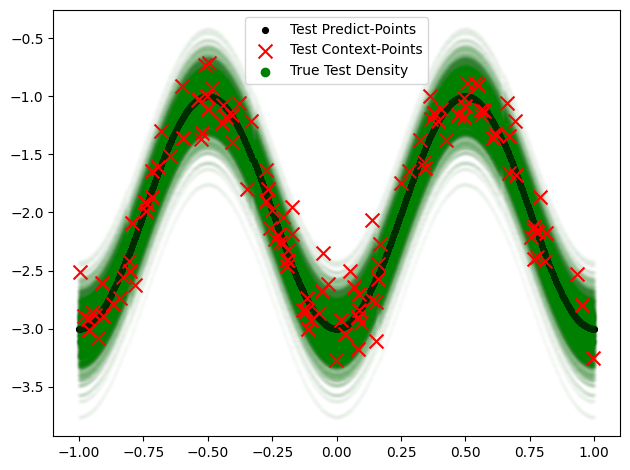

In [471]:
def f(
    key: flax.typing.PRNGKey, 
    x: jax.Array, 
    noise_scale: float = 0.2, 
    mixture_prob: float = 0.5, 
    corrupt: bool = True
):
    key_noise, key_mixture = jax.random.split(key)
    noise = jax.random.normal(key, x.shape) * noise_scale
    return (-2-jnp.cos(2 * jnp.pi * x)) + corrupt * noise

# Generate test data for visualization
rng, key_data, key_test, key_x = jax.random.split(rng, 4)
keys_data = jax.random.split(key_data, dataset_size)
keys_test = jax.random.split(key_test, test_resolution)

xs = jax.random.uniform(key_x, (dataset_size,)) * 2 - 1
ys = jax.vmap(f)(keys_data, xs)

x_test = jnp.linspace(-1, 1, test_resolution)
y_test = jax.vmap(partial(f, corrupt=False))(keys_test, x_test)
y_test_samples = jax.vmap(jax.vmap(partial(f, corrupt=True), in_axes=(0, None)), in_axes=(None, 0))(keys_test, x_test)

# True Function
plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')
plt.scatter(jnp.broadcast_to(x_test, y_test_samples.shape).T, y_test_samples, c='green', s=5, marker='o', linewidth=2, alpha=0.01)
plt.scatter(xs, ys, c='red', marker='x', s=100, label='Test Context-Points')
plt.scatter([], [], c='green', marker='o', label='True Test Density')
plt.legend()
plt.tight_layout()
plt.show()


In [53]:
# Construct the NP model

embedding_xs = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_ys = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_both = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)

projection_posterior = NonLinearMVN(MLP([128, 64], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True))
output_model = nn.Sequential([
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    nn.Dense(2)
])
# output_model = MLP([64, 64, 2], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True)
projection_outputs = NonLinearMVN(output_model)

posterior_aggregator = MeanAggregator(projection_posterior)
# posterior_aggregator = SequenceAggregator(projection_posterior)

model = MixtureNeuralProcess(
    embedding_xs, embedding_ys, embedding_both, 
    posterior_aggregator, 
    projection_outputs
)

In [54]:
# Define how the model loss should be computed

def posterior_loss(
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    sampling_fun: Callable[
        [flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ] = data_sampler
):
    # Sample datasets from p(X, Y, Z)
    key_data, key_model = jax.random.split(key)
    xs, ys = jax.vmap(data_sampler)(jax.random.split(key_data, num=batch_size))
    xs, ys = xs[..., None], ys[..., None]
    
    # Split into context- and target-points.
    X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)

    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, num=batch_size)}
    )
    
    return -elbos.mean()


def posterior_loss_filtered(
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    sampling_fun: Callable[
        [flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ] = data_sampler
):
    # Sample datasets from p(X, Y, Z)
    key_data, key_model = jax.random.split(key)
    xs, ys = jax.vmap(data_sampler)(jax.random.split(key_data, num=batch_size))
    xs, ys = xs[..., None], ys[..., None]
    
    # Split into context- and target-points.
    X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)

    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, num=batch_size)}
    )

    # Mask out all samples with higher data-likelihood than the worst 40%
    q40 = jnp.percentile(elbos, 40)
    mask = elbos <= q40
    
    return -(elbos * mask / mask.sum()).sum()


NameError: name 'data_sampler' is not defined

In [9]:
@jax.jit
def step(
    theta: flax.typing.VariableDict, 
    opt_state: optax.OptState, 
    random_key: flax.typing.PRNGKey
) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
    
    value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
    # value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, random_key)
    
    updates, opt_state = optimizer.update(grad, opt_state, theta)
    theta = optax.apply_updates(theta, updates)
    
    return theta, opt_state, value


In [10]:
def body(carry, x):
    params, opt_state, key = carry

    key_carry, key_step = jax.random.split(key)
    params, opt_state, value = step(params, opt_state, key_step)

    return (params, opt_state, key_carry), value


@partial(jax.jit, static_argnums=3)
def scan_train(params, opt_state, key, num: int):
    
    last, out = jax.lax.scan(body, (params, opt_state, key), xs=None, length=num)

    params, opt_state, _ = last
    
    return params, opt_state, out

In [11]:
scan_chunk = 100

# Initialize the Optimization.
rng, key = jax.random.split(rng)

last_key = key
print(last_key)
xs = jax.random.uniform(key, (128,)) * 2 - 1

params = params0 = model.init(
    {'params': key, 'default': key}, 
    xs[:, None], xs[:, None], xs[:3, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)

[1278412471 2182328957]


In [73]:
num_training_steps = 100
baseline_data_sampler = data_sampler

In [106]:
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
for i in (pbar := tqdm.trange(6_000 // scan_chunk, desc='Optimizing params. ')):
    
    rng, key = jax.random.split(rng)
    # params_new, opt_state, loss = step(params, opt_state, key)
    params_new, opt_state, loss_arr = scan_train(params, opt_state, key, scan_chunk)

    losses.append(loss_arr)

    if loss_arr.min() < best:
        best = loss_arr.min()
        best_params = params_new
    
    if jnp.isnan(loss_arr).any():
        break
    else:
        params = params_new
    
    pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

params = best_params
losses = jnp.asarray(losses).ravel()

Optimizing params. :   0%|          | 0/60 [00:00<?, ?it/s]

Optimizing params. :   0%|          | 0/60 [00:00<?, ?it/s]


TypeError: Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(int32[])>with<BatchTrace(level=6/0)> with
  val = Traced<ShapedArray(int32[128])>with<DynamicJaxprTrace(level=3/0)>
  batch_dim = 0,).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
This BatchTracer with object id 2711737965184 was created on line:
  C:\Users\onerk\AppData\Local\Temp\ipykernel_29968\4103194228.py:12 (<lambda>)

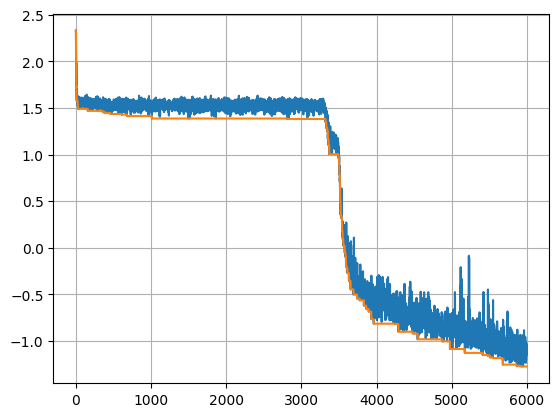

In [100]:
losses = jnp.asarray(losses).ravel()
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()

In [57]:
class Fourier_nr(nn.Module):
    """Generate random functions as the sum of randomized sine waves

    i.e. (simplified),
        z = scale * x - shift,
        y = a_0 + sum_(i=1...n) a_i cos(2pi * i * z - phi_i),
    where a_i are amplitudes and phi_i are phase shifts.

    See the Amplitude-Phase form,
     - https://en.wikipedia.org/wiki/Fourier_series
    """
    n: int = 3
    period: float = 1.0
    amplitude: jax.typing.ArrayLike = jnp.array([1.0, 0.5, 0.25])
    phase: jax.typing.ArrayLike = jnp.array([0.0, jnp.pi/4, jnp.pi/2])

    # def setup(self):
    #     # Ensure amplitude and phase are jax arrays
    #     self.amplitude = jnp.array(self.amplitude)
    #     self.phase = jnp.array(self.phase)

    @nn.compact
    def __call__(self, x: jax.typing.ArrayLike) -> jax.Array:
        # shift = self.param(
        #     'shift',
        #     nn.initializers.uniform(scale=jnp.pi),
        #     jnp.shape(x), x.dtype
        # )

        # x = x - shift

        # (heuristic) Monotonically scale amplitudes.
        amplitude = self.amplitude * jnp.arange(1, len(self.amplitude) + 1) / (self.n - 1)

        waves = jnp.cos(
            (2 * jnp.pi * jnp.arange(1, self.n) * x - self.phase) / self.period
        )

        return amplitude[0] / 2.0 + jnp.sum(amplitude[1:] * waves, axis=0)

In [58]:
def joint_r(
    modules: List[nn.Module], 
    data_sampler: Callable[[nn.Module, flax.typing.VariableDict, flax.typing.PRNGKey], tuple[jax.Array, jax.Array]],
    key: flax.typing.PRNGKey, 
    return_params: bool = False
) -> tuple[jax.Array, jax.Array]:
    key_param, key_rng, key_data, key_select = jax.random.split(key, 4)
    module_idx = jax.random.randint(key_select, (), 0, len(modules))
    module = modules[module_idx]
    params = module.init({'param': key_param, 'default': key_rng}, jnp.zeros(()))
    xs, ys = data_sampler(module, params, key_data)
    if return_params:
        return xs, ys, params
    return xs, ys


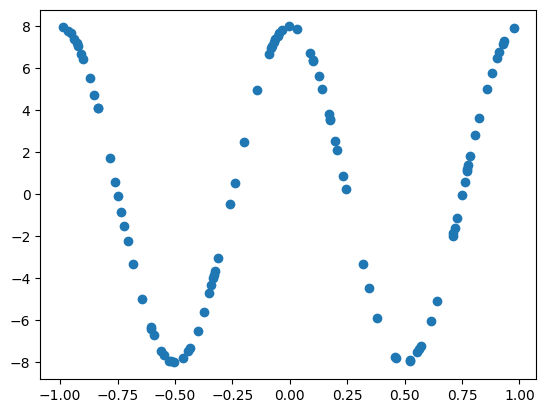

In [59]:
fourier_instances = [
    Fourier_nr(n=2, amplitude=jnp.array([1.0, 0.5]), phase=jnp.array([0.0])),
    Fourier_nr(n=4, amplitude=jnp.array([1.0, 0.6, 0.3, 0.1]), phase=jnp.array([jnp.pi/8, jnp.pi/3, jnp.pi/2])),
    Fourier_nr(n=6, amplitude=jnp.array([3.0, 2, 1, 0.1, 0.05, 0.025]), phase=jnp.array([0.0, jnp.pi/6, jnp.pi/3, jnp.pi/2, 2*jnp.pi/3]))
]

fourier_instances = [
    Fourier_nr(n=2, amplitude=jnp.array([0, 1]), phase=jnp.array([0.0])),
    Fourier_nr(n=2, amplitude=jnp.array([0, 4]), phase=jnp.array([0.0])),
    Fourier_nr(n=2, amplitude=jnp.array([0, 8]), phase=jnp.array([0.0]))
]

# Partial function for data_sampler
data_sampler_partial = partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))

# Create the data sampler function that selects a random Fourier instance
data_sampler_deneme = partial(joint_r, fourier_instances, data_sampler_partial)
rng, key = jax.random.split(rng)
x, y = data_sampler_deneme(key)
plt.scatter(x, y)

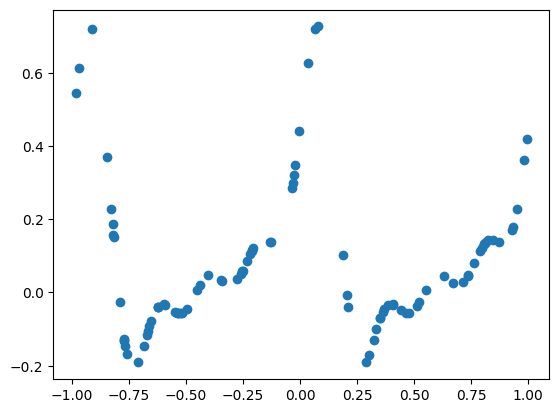

In [60]:
fourier_instance = Fourier_nr(
    n=5,
    amplitude=jnp.array([1.0, 0.5, 0.25, 0.125, 0.0625]),
    phase=jnp.array([0.0, jnp.pi/4, jnp.pi/2, 3*jnp.pi/4]),
    period=1
)


#data_sampler_nr = partial(joint, f_nr1, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
data_sampler_deneme = partial(joint, fourier_instance, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
rng, key = jax.random.split(rng)
x, y = data_sampler_deneme(key)
plt.scatter(x, y)

In [61]:
fourier_instance_range = Fourier_range(
    n_range=[2, 6],
    period_range=[0.5, 2.0],
    amplitude_range=[1, 2.0],
    phase_range=[0.0, jnp.pi]
)


#data_sampler_nr = partial(joint, f_nr1, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
data_sampler_range = partial(joint, fourier_instance_range, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
rng, key = jax.random.split(rng)
x, y = data_sampler_range(key)
plt.scatter(x, y)

TypeError: Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = Array([2, 3, 2, 4, 3, 5, 6, 3, 3, 3, 6, 3, 3, 2, 3, 2, 2, 6, 6, 5, 3, 6,
       6, 2, 3, 6, 4, 3, 4, 4, 6, 3, 2, 5, 6, 4, 6, 6, 6, 6, 3, 6, 3, 2,
       5, 3, 4, 3, 2, 2, 5, 4, 4, 4, 3, 4, 5, 5, 6, 5, 2, 6, 3, 4, 6, 3,
       5, 5, 3, 3, 5, 5, 3, 2, 5, 2, 5, 6, 6, 2, 4, 4, 5, 3, 4, 2, 5, 6,
       2, 5, 5, 4, 3, 6, 4, 4], dtype=int32)
  batch_dim = 0,).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
This BatchTracer with object id 2341358531296 was created on line:
  C:\Users\onerk\AppData\Local\Temp\ipykernel_32864\1694067279.py:11 (generate_params)

In [13]:
def RMSE_means(model, params, x_context, y_context, x_target, y_target, rng, k):
    
    y_means, y_stds = model.apply(params, x_context, y_context, x_target,k=k, rngs={'default': rng}) 
    
    
    return jnp.sqrt(jnp.mean((y_means - y_target)**2))

In [62]:
# Dummy fitness calculation function (to be replaced with actual regressor model loss inversion)
def calculate_fitness(chromosome: Chromosome, key, num_evaluation_samples: int = 1, model=model, params=params) -> float:
    # Create a Fourier instance from the chromosome
    fourier_instance = Fourier_nr(
        n=chromosome['n'],
        period=chromosome['period'],
        amplitude=jnp.array(chromosome['amplitudes']),
        phase=jnp.array(chromosome['phases'])
    )
        # Calculate the loss using the provided evaluate_model function
    # losses = []
    # for _ in range(num_evaluation_samples):
    #     key, subkey = jax.random.split(key)
    #     data_sampler_real = partial(joint, fourier_instance, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
    #     x, y = data_sampler_real(subkey)
    #     x, y = x[..., None], y[..., None]
    #     X, x_test = jnp.split(x, indices_or_sections=(num_context_samples,))
    #     y, y_test = jnp.split(y, indices_or_sections=(num_context_samples,))
    data_sampler_real = partial(joint, fourier_instance, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
    x, y = jax.vmap(data_sampler_real)(jax.random.split(key, num_evaluation_samples)) 
    x, y = x[..., None], y[..., None]

    #lets split them into the context and target sets
    x_contexts, x_targets = jnp.split(x, indices_or_sections=(num_context_samples, ), axis=1)
    y_contexts, y_targets = jnp.split(y, indices_or_sections=(num_context_samples, ), axis=1)
    key, subkey = jax.random.split(key)
    ece_errors = nk.jax.vmap_chunked(partial(RMSE_means, model, params, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=128*100)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(subkey, num_evaluation_samples))

    #losses.append(loss)
    average_loss = jnp.mean(jnp.array(ece_errors))
    return 1 / (average_loss + 1e-8)

In [63]:
import random
import numpy as np
from typing import List, Dict, Tuple

# Define chromosome structure
Chromosome = Dict[str, np.ndarray]

# Initialize population with random chromosomes
def initialize_population(pop_size: int, n_range: Tuple[int, int], period_range: Tuple[float, float], amplitude_range: Tuple[float, float], phase_range: Tuple[float, float]) -> List[Chromosome]:
    population = []
    for _ in range(pop_size):
        n = random.randint(n_range[0], n_range[1])
        period = random.uniform(period_range[0], period_range[1])
        amplitudes = np.random.uniform(amplitude_range[0], amplitude_range[1], size=(n,))
        phases = np.random.uniform(phase_range[0], phase_range[1], size=(n-1,))
        chromosome = {
            'n': n,
            'period': period,
            'amplitudes': amplitudes,
            'phases': phases
        }
        population.append(chromosome)
    return population

# Crossover between two parent chromosomes
def crossover(parent1: Chromosome, parent2: Chromosome) -> Chromosome:
    child = {}
    
    # Choose n and period from parents
    n1, n2 = parent1['n'], parent2['n']
    n = random.choice([n1, n2])
    period = random.uniform(parent1['period'], parent2['period'])

    # Interpolate amplitudes and phases
    amplitudes1 = np.copy(parent1['amplitudes'])
    amplitudes2 = np.copy(parent2['amplitudes'])
    phases1 = np.copy(parent1['phases'])
    phases2 = np.copy(parent2['phases'])
    if n1 < n2:
        amplitudes1 = np.pad(parent1['amplitudes'], (0, n2 - n1), mode='constant', constant_values=0)
        phases1 = np.pad(parent1['phases'], (0, n2 - n1), mode='constant', constant_values=0)
    else:
        amplitudes2 = np.pad(parent2['amplitudes'], (0, n1 - n2), mode='constant', constant_values=0)
        phases2 = np.pad(parent2['phases'], (0, n1 - n2), mode='constant', constant_values=0)
    
    amplitudes = np.array([random.choice([a, b]) for a, b in zip(amplitudes1, amplitudes2)])
    phases = np.array([random.choice([a, b]) for a, b in zip(phases1, phases2)])
    
    # Select correct number of amplitudes and phases for the child
    child['n'] = n
    child['period'] = period
    child['amplitudes'] = amplitudes[:n]
    child['phases'] = phases[:n-1]

    return child

# Mutation function to introduce variations
def mutate(chromosome: Chromosome, n_range: Tuple[int, int], period_range: Tuple[float, float], amplitude_range: Tuple[float, float], phase_range: Tuple[float, float], mutation_rate: float) -> Chromosome:
    if random.uniform(0, 1) < mutation_rate:
        new_n = int(np.round(np.random.normal(chromosome['n'], (n_range[1] - n_range[0])) / 16))
        # # Ensure the new n is within the range
        new_n = max(n_range[0], min(n_range[1], new_n))
        original_n = chromosome['n']
        chromosome['n'] = new_n
        
        if chromosome['n'] != original_n:
            if chromosome['n'] > original_n:
                # Increase the size of the arrays
                additional_amplitudes = np.random.uniform(amplitude_range[0], amplitude_range[1], size=(chromosome['n'] - original_n,))
                additional_phases = np.random.uniform(phase_range[0], phase_range[1], size=(chromosome['n'] - original_n,))
                chromosome['amplitudes'] = np.concatenate((chromosome['amplitudes'], additional_amplitudes))
                chromosome['phases'] = np.concatenate((chromosome['phases'], additional_phases))
            else:
                # Decrease the size of the arrays
                chromosome['amplitudes'] = chromosome['amplitudes'][:chromosome['n']]
                chromosome['phases'] = chromosome['phases'][:chromosome['n'] - 1]


    if random.uniform(0, 1) < mutation_rate:
        new_period = np.random.normal(chromosome['period'], (period_range[1] - period_range[0]) / 16)
        new_period = max(period_range[0], min(period_range[1], new_period))
        chromosome['period'] = new_period
    if random.uniform(0, 1) < mutation_rate:
        for idx, amplitude in enumerate(chromosome['amplitudes']):
            new_amplitude = np.random.normal(amplitude, (amplitude_range[1] - amplitude_range[0]) / 16)
            new_amplitude = max(amplitude_range[0], min(amplitude_range[1], amplitude))
            chromosome['amplitudes'][idx] = new_amplitude
        
        #chromosome['amplitudes'] = np.random.uniform(amplitude_range[0], amplitude_range[1], size=(chromosome['n'],))
    if random.uniform(0, 1) < mutation_rate:
        for idx, phase in enumerate(chromosome['phases']):
            new_phase = np.random.normal(phase, (phase_range[1] - phase_range[0]) / 16)
            new_phase = max(phase_range[0], min(phase_range[1], new_phase))
            chromosome['phases'][idx] = new_phase
        
        #chromosome['phases'] = np.random.uniform(phase_range[0], phase_range[1], size=(chromosome['n'] - 1,))
    return chromosome

# Evolutionary loop
def evolutionary_algorithm(pop_size: int, generations: int, n_range: Tuple[int, int], period_range: Tuple[float, float], amplitude_range: Tuple[float, float], phase_range: Tuple[float, float], mutation_rate: float, top_k: int, retain_rate, rng):
    population = initialize_population(pop_size, n_range, period_range, amplitude_range, phase_range)
    best_fitness_log = []
    
    for generation in range(generations):
        # Evaluate fitness
        #rng, key = jax.random.split(rng)
        fitness_scores = [calculate_fitness(individual, key, num_evaluation_samples = 1) for individual in population]
        
        # Log best fitness for this generation
        best_fitness_log.append(max(fitness_scores))
        print(f"Generation {generation}: Best fitness - {max(fitness_scores)}")
        #average fitness
        print(f"Generation {generation}: Average fitness - {jnp.mean(jnp.array(fitness_scores))}")

        # Select parents based on fitness
        #normalize fitness scores to 0, 1
        fitness_scores = np.array(fitness_scores)
        #fitness_scores = (fitness_scores - fitness_scores.min()) / (fitness_scores.max() - fitness_scores.min())
        sorted_indices = np.argsort(fitness_scores)[::-1]
        sorted_population = [population[i] for i in sorted_indices]
        sorted_fitness_scores = [fitness_scores[i] for i in sorted_indices]
        
        # Retain a certain percentage of the top performers
        num_retained = int(pop_size * retain_rate)
        retained_population = sorted_population[:num_retained]
        
        # Breed the rest
        num_breed = pop_size - num_retained
        parents = random.choices(sorted_population, weights=sorted_fitness_scores, k=num_breed)
        next_generation = [crossover(random.choice(parents), random.choice(parents)) for _ in range(num_breed)]
        
        # # Create next generation through crossover
        # next_generation = [crossover(random.choice(parents), random.choice(parents)) for _ in range(pop_size)]
        
        # Apply mutation
        next_generation = [mutate(individual, n_range, period_range, amplitude_range, phase_range, mutation_rate) for individual in next_generation]
        
        population = retained_population + next_generation
    
    # Evaluate fitness for the final population
    fitness_scores = [calculate_fitness(individual, key, num_evaluation_samples=1) for individual in population]
    
    # Get the top_k best individuals
    best_indices = np.argsort(fitness_scores)[-top_k:]
    best_individuals = [population[i] for i in best_indices]
    
    return best_individuals, best_fitness_log

Generation 0: Best fitness - 0.3820371825551776
Generation 0: Average fitness - 0.14713351253298013
Generation 1: Best fitness - 1.1757535390573268
Generation 1: Average fitness - 0.19400523602722836
Generation 2: Best fitness - 1.3647692726654368
Generation 2: Average fitness - 0.2416011731367027
Generation 3: Best fitness - 1.3647692726654368
Generation 3: Average fitness - 0.3384912692827999
Generation 4: Best fitness - 5.741964416163941
Generation 4: Average fitness - 0.5022252917402532
Generation 5: Best fitness - 12.404130514042475
Generation 5: Average fitness - 1.279203998204404
Generation 6: Best fitness - 12.404130514042475
Generation 6: Average fitness - 2.5088656690687365
Generation 7: Best fitness - 15.443306272564056
Generation 7: Average fitness - 4.109019976844886
Generation 8: Best fitness - 16.227817754182173
Generation 8: Average fitness - 5.961892777129317
Generation 9: Best fitness - 16.227817754182173
Generation 9: Average fitness - 7.31996441359381
Best solutions

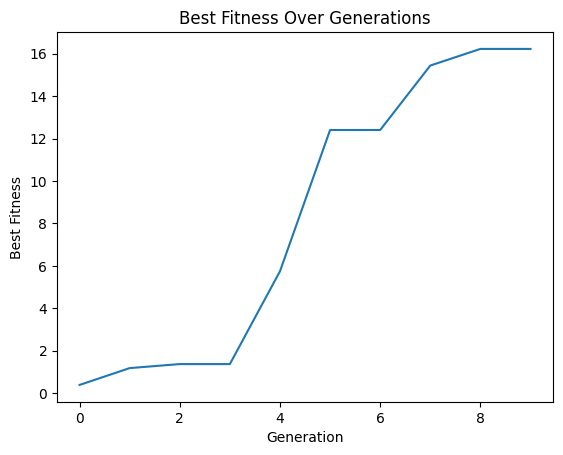

In [460]:
# Example usage
n_range = (2, 7)
period_range = (0.5, 2.0)
amplitude_range = (0.1, 10.0)
phase_range = (0.0, np.pi)
mutation_rate = 0.25
pop_size = 100
generations = 10
top_k = 3
chunk_size = 128*100
retain_rate = 0.5
key = rng = jax.random.key(0)


best_solutions, best_fitness_log = evolutionary_algorithm(pop_size, generations, n_range, period_range, amplitude_range, phase_range, mutation_rate, top_k, retain_rate, rng)

print("Best solutions:", best_solutions)
print("Best fitness log:", best_fitness_log)

# Plot the best fitness log
plt.plot(best_fitness_log)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness Over Generations')
plt.show()

Generation 0: Best fitness - 1.588419005611119
Generation 0: Average fitness - 0.16783931936078822
Generation 1: Best fitness - 1.8723435611038366
Generation 1: Average fitness - 0.3426556690705975
Generation 2: Best fitness - 4.5867441733521135
Generation 2: Average fitness - 0.6844160592293187
Generation 3: Best fitness - 8.08682602743956
Generation 3: Average fitness - 1.237932675853507
Generation 4: Best fitness - 8.08682602743956
Generation 4: Average fitness - 1.7995244346469021
Generation 5: Best fitness - 8.08682602743956
Generation 5: Average fitness - 2.4998689832047827
Generation 6: Best fitness - 8.08682602743956
Generation 6: Average fitness - 2.921967285184058
Generation 7: Best fitness - 12.66424407600275
Generation 7: Average fitness - 4.108131157413145
Generation 8: Best fitness - 12.66424407600275
Generation 8: Average fitness - 5.57749993613116
Generation 9: Best fitness - 13.508349195207717
Generation 9: Average fitness - 6.782475068631259
Best solutions: [{'n': 6, 

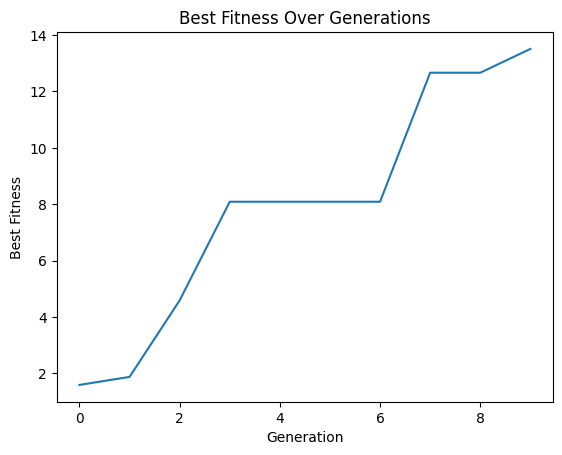

In [458]:
# Example usage
n_range = (2, 7)
period_range = (0.5, 2.0)
amplitude_range = (0.1, 10.0)
phase_range = (0.0, np.pi)
mutation_rate = 0
pop_size = 100
generations = 10
top_k = 3
chunk_size = 128*100
retain_rate = 0.5
key = rng = jax.random.key(0)


best_solutions, best_fitness_log = evolutionary_algorithm(pop_size, generations, n_range, period_range, amplitude_range, phase_range, mutation_rate, top_k, retain_rate, rng)

print("Best solutions:", best_solutions)
print("Best fitness log:", best_fitness_log)

# Plot the best fitness log
plt.plot(best_fitness_log)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness Over Generations')
plt.show()

In [416]:
import netket as nk

c:\TU Delft\YEAR 3\RP\bsc_students\bsc_students\RP-2024\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generation 0: Best fitness - 0.5030820587373576
Generation 0: Average fitness - 0.15701643644368726
Generation 1: Best fitness - 1.109875355916786
Generation 1: Average fitness - 0.23258742914690253
Generation 2: Best fitness - 3.2577023072979556
Generation 2: Average fitness - 0.43694808794702616
Generation 3: Best fitness - 3.258548491057443
Generation 3: Average fitness - 0.7773452755425965
Generation 4: Best fitness - 4.217800607695226
Generation 4: Average fitness - 1.2343135385664075
Generation 5: Best fitness - 6.233536028281278
Generation 5: Average fitness - 1.9389882465747343
Generation 6: Best fitness - 6.241479026431961
Generation 6: Average fitness - 2.758125567463353
Generation 7: Best fitness - 6.2416520961332065
Generation 7: Average fitness - 4.0527137808244005
Generation 8: Best fitness - 6.301168121662759
Generation 8: Average fitness - 4.386990313620689
Generation 9: Best fitness - 6.300515312128715
Generation 9: Average fitness - 5.134992564950722
Best solutions: [

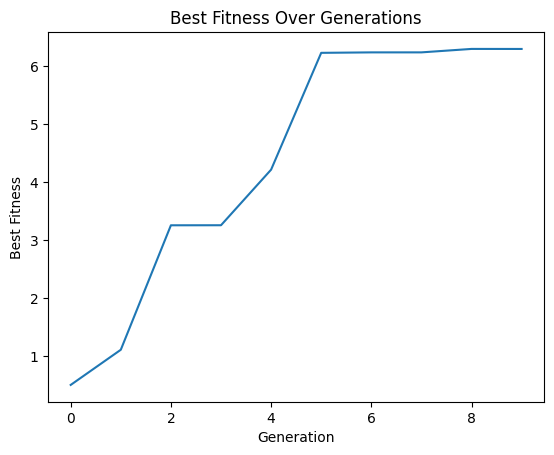

In [434]:
# Example usage
n_range = (2, 7)
period_range = (0.5, 2.0)
amplitude_range = (0.1, 10.0)
phase_range = (0.0, np.pi)
mutation_rate = 0
pop_size = 100
generations = 10
top_k = 3
chunk_size = 128*100
key = rng = jax.random.key(0)


best_solutions, best_fitness_log = evolutionary_algorithm(pop_size, generations, n_range, period_range, amplitude_range, phase_range, mutation_rate, top_k, rng)

print("Best solutions:", best_solutions)
print("Best fitness log:", best_fitness_log)

# Plot the best fitness log
plt.plot(best_fitness_log)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness Over Generations')
plt.show()

In [464]:
# Example usage
n_range = (2, 7)
period_range = (0.5, 2.0)
amplitude_range = (0.1, 10.0)
phase_range = (0.0, np.pi)
mutation_rate = 0.25
pop_size = 100
generations = 10
top_k = 3
chunk_size = 128*100
retain_rate = 0.5
key = rng = jax.random.key(0)


best_solutions, best_fitness_log = evolutionary_algorithm(pop_size, generations, n_range, period_range, amplitude_range, phase_range, mutation_rate, top_k, retain_rate, rng)

print("Best solutions:", best_solutions)
print("Best fitness log:", best_fitness_log)

# Plot the best fitness log
plt.plot(best_fitness_log)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness Over Generations')
plt.show()

Generation 0: Best fitness - 0.4430197096634992
Generation 0: Average fitness - 0.1574890509815452
Generation 1: Best fitness - 0.7626340078329017
Generation 1: Average fitness - 0.197393981766055
Generation 2: Best fitness - 1.3274521468710916
Generation 2: Average fitness - 0.25939840695665906
Generation 3: Best fitness - 1.4198080163034121
Generation 3: Average fitness - 0.36353822968691896
Generation 4: Best fitness - 5.324631915336957
Generation 4: Average fitness - 0.5120446686117933
Generation 5: Best fitness - 5.89999747612741
Generation 5: Average fitness - 1.087380749564384
Generation 6: Best fitness - 6.901038876513065
Generation 6: Average fitness - 2.1380535506719727
Generation 7: Best fitness - 7.230379805713619
Generation 7: Average fitness - 3.5927243128088855
Generation 8: Best fitness - 7.58018976718273
Generation 8: Average fitness - 4.851921767529476


KeyboardInterrupt: 

In [64]:
def random_integer_initializer(minval, maxval, dtype=jnp.int32):
    def init(key, shape, dtype=dtype):
        return jax.random.randint(key, shape, minval=minval, maxval=maxval, dtype=dtype)
    return init


In [65]:
class Fourier_range(nn.Module):
    n: int
    period_range: Tuple[float, float]
    amplitude_range: Tuple[float, float]
    phase_range: Tuple[float, float]

    def setup(self):
        
        self.period = self.param(
            'period', 
            nn.initializers.uniform(scale=self.period_range[1] - self.period_range[0]), 
            ()
        ) + self.period_range[0]

        self.amplitude = self.param(
            'amplitude', 
            nn.initializers.uniform(scale=self.amplitude_range[1] - self.amplitude_range[0]), 
            (self.n,)
        ) + self.amplitude_range[0]
        
        self.phase = self.param(
            'phase', 
            nn.initializers.uniform(scale=self.phase_range[1] - self.phase_range[0]), 
            (self.n - 1,)
        ) + self.phase_range[0]


    @nn.compact
    def __call__(self, x: jax.typing.ArrayLike) -> jax.Array:
        shift = self.param(
            'shift',
            nn.initializers.uniform(scale=jnp.pi),
            jnp.shape(x), x.dtype
        )
        x = x - shift
        amplitude = self.amplitude * jnp.arange(1, len(self.amplitude) + 1) / (self.n - 1)
        waves = jnp.cos(
            (2 * jnp.pi * jnp.arange(1, self.n) * x - self.phase) / self.period
        )

        return amplitude[0] / 2.0 + jnp.sum(amplitude[1:] * waves, axis=0)

In [66]:
#data_sampler = partial(joint, f2, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
fourier_instance_range = Fourier_range(
    n=2,
    period_range=[0.5, 2.0],
    amplitude_range=[1, 10],
    phase_range=[0.0, jnp.pi]
)


#data_sampler_nr = partial(joint, f_nr1, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
data_sampler_range = data_sampler = partial(joint, fourier_instance_range, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))

In [67]:
#data_sampler = partial(joint, Fourier_nr(n=4, amplitude=jnp.array([1.0, 0.6, 0.3, 0.1]), phase=jnp.array([jnp.pi/8, jnp.pi/3, jnp.pi/2])), partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
x, y = jax.vmap(data_sampler)(jax.random.split(rng, dataset_size)) 
x, y = x[..., None], y[..., None]

In [91]:
print(x.shape)
print(y.shape)

(128, 96, 1)
(128, 96, 1)


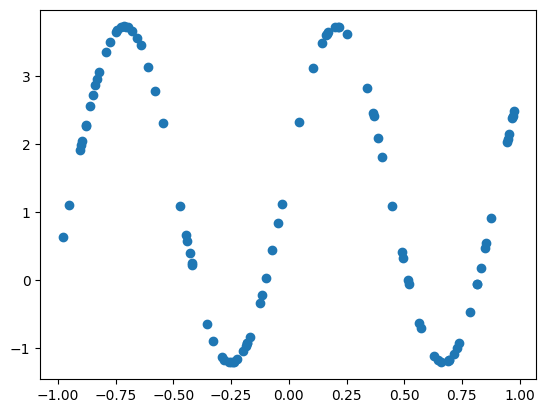

In [68]:
plt.scatter(x[2], y[2])

In [222]:
period_range=[0.05, 2.0]
amplitude_range=[0.1, 10.0]
phase_range=[0.0, jnp.pi]
n_range = [3, 6]

fouriers = [Fourier_range(n=i, period_range=period_range, amplitude_range=amplitude_range, phase_range=phase_range) for i in range(n_range[0], n_range[1] + 1)]
samplers = [partial(joint, fourier, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))) for fourier in fouriers]
#equal ratios
ratios = [1.0 / (len(fouriers)) for _ in fouriers[:len(fouriers) - 1]]
ratios = ratios + [1.0 - sum(ratios)]
print(fouriers)
fourier_instance_range_2 = Fourier_range(
    n=2,
    period_range=[0.5, 2.0],
    amplitude_range=[1, 10],
    phase_range=[0.0, jnp.pi]
)

[Fourier_range(
    # attributes
    n = 3
    period_range = [0.05, 2.0]
    amplitude_range = [0.1, 10.0]
    phase_range = [0.0, 3.141592653589793]
), Fourier_range(
    # attributes
    n = 4
    period_range = [0.05, 2.0]
    amplitude_range = [0.1, 10.0]
    phase_range = [0.0, 3.141592653589793]
), Fourier_range(
    # attributes
    n = 5
    period_range = [0.05, 2.0]
    amplitude_range = [0.1, 10.0]
    phase_range = [0.0, 3.141592653589793]
), Fourier_range(
    # attributes
    n = 6
    period_range = [0.05, 2.0]
    amplitude_range = [0.1, 10.0]
    phase_range = [0.0, 3.141592653589793]
)]


In [223]:
from dataset_generation import joint, uniform, RegressionDataset , generate_noisy_split_trainingdata
from torch.utils.data import DataLoader
#samplers = [data_sampler_range]
rng, dataset_key = jax.random.split(rng)
chunk_size = 64*100
data_set_size = 64 * 1000
batch_size = 64
dataset = RegressionDataset(generate_noisy_split_trainingdata(samplers, ratios, data_set_size, chunk_size , dataset_key))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Dataset length: 64000
Shape of a single sample: (96, 1)


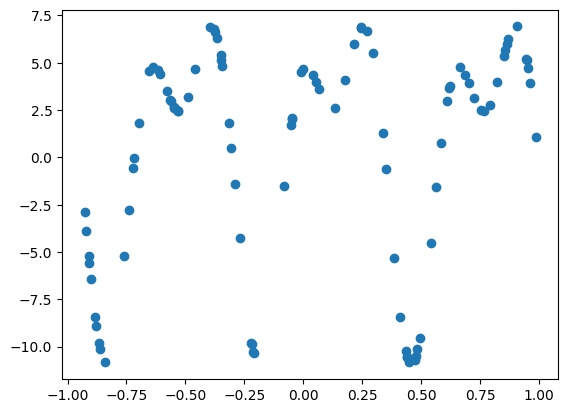

In [224]:
dataset_length = len(dataset)

# Get the shape of a single sample
sample_shape = dataset[0][0].shape if isinstance(dataset[0], tuple) else dataset[0].shape

print(f"Dataset length: {dataset_length}")
print(f"Shape of a single sample: {sample_shape}")
i = 17
plt.scatter(dataset[i][0], dataset[i][1])


In [204]:
def posterior_loss(
    params: flax.typing.VariableDict,
    batch,
    key: flax.typing.PRNGKey,
):
    key_data, key_model = jax.random.split(key)
    


    X = batch[0]
    y = batch[1]
    x_test = batch[2]
    y_test = batch[3]
    # Compute ELBO over batch of datasets
    elbos = jax.vmap(
    partial(
            model.apply,
            params,  
            beta=kl_penalty,
            k=num_posterior_mc,
            method=model.elbo
    ) 
    )(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, X.shape[0])}
    )
    
    return -elbos.mean()

@jax.jit
def step(
    theta: flax.typing.VariableDict, 
    opt_state: optax.OptState,
    current_batch,
    random_key: flax.typing.PRNGKey,
) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
    # Implements a generic SGD Step
    
    # value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
    value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, current_batch, random_key )
    
    updates, opt_state = optimizer.update(grad, opt_state, theta)
    theta = optax.apply_updates(theta, updates)
    
    return theta, opt_state, value


def body_batch(carry, batch):
    params, opt_state, key = carry
    key_carry, key_step = jax.random.split(key)
    # Unpack the batch
    X_full, y_full = batch

    # Shuffle the data while preserving (X, y) pairs
    num_samples = X_full.shape[1]
    indices = jax.random.permutation(key_step, num_samples)
    X_full_shuffled = jnp.take(X_full, indices, axis=1)
    y_full_shuffled = jnp.take(y_full, indices, axis=1)

    # Split the shuffled data into context and test sets
    X, x_test = jnp.split(X_full_shuffled, indices_or_sections=(num_context_samples,), axis=1)
    y, y_test = jnp.split(y_full_shuffled, indices_or_sections=(num_context_samples,), axis=1)

    params, opt_state, value = step(params, opt_state, (X,y, x_test,y_test ), key_step )

    return (params, opt_state, key_carry ), value

@jax.jit
def scan_train(params, opt_state, key,  batches):
    
    last, out = jax.lax.scan(body_batch, (params, opt_state, key ), batches)

    params, opt_state, _ = last
    
    return params, opt_state, out

In [205]:
def create_model(rng):
    embedding_xs = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
    embedding_ys = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
    embedding_both = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)

    projection_posterior = NonLinearMVN(MLP([128, 64], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True))
    output_model = nn.Sequential([
        ResBlock(
            MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
        ),
        ResBlock(
            MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
        ),
        nn.Dense(2)
    ])
    # output_model = MLP([64, 64, 2], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True)
    projection_outputs = NonLinearMVN(output_model)

    posterior_aggregator = MeanAggregator(projection_posterior)
    # posterior_aggregator = SequenceAggregator(projection_posterior)

    model = MixtureNeuralProcess(
        embedding_xs, embedding_ys, embedding_both, 
        posterior_aggregator, 
        projection_outputs
    )

    rng, data_init_rng = jax.random.split(rng)

    xs = jax.random.uniform(data_init_rng, (128,)) * 2 - 1

    rng, key = jax.random.split(rng)
    params = model.init({'params': key, 'default': key}, xs[:, None], xs[:, None], xs[:3, None])

    return model, params

In [206]:
def cross_entropy_error(model, params, x_context, y_context, x_target, y_target , rng , k):
    y_means, y_stds = model.apply(params, x_context, y_context, x_target,k=k, rngs={'default': rng})


    # Lets compute the log likelihood of the target points given the means and stds

    # Ensure y_means and y_stds are squeezed correctly
    y_means = jnp.squeeze(y_means, axis=-1) if k > 1 else jnp.squeeze(y_means)
    y_stds = jnp.squeeze(y_stds, axis=-1) if k > 1 else jnp.squeeze(y_stds)
    full_y = jnp.squeeze(y_target, axis=-1) if k > 1 else jnp.squeeze(y_target) 

    log_pdf = logpdf(full_y, y_means,y_stds) 
   


    return -jnp.mean(log_pdf)



def RMSE_means(model, params, x_context, y_context, x_target, y_target, rng, k):
    
    y_means, y_stds = model.apply(params, x_context, y_context, x_target,k=k, rngs={'default': rng}) 
    
    
    return jnp.sqrt(jnp.mean((y_means - y_target)**2))

In [120]:
from model_utils import save_model_params, load_model_params
import pickle
import os
import netket as nk
from jax.scipy.stats.norm import logpdf
save_path="./baseline_deneme3/"
model_name="base_0_1_"
os.makedirs(save_path, exist_ok=True)
eval_intervals = 250
training_step_number = 5000
eval_dataset_size = 1000

model , params = create_model(key)
optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
in_task_errors = {'ece':[], 'rmse':[], 'std_residuals':[], "ece_noise" : [], "rmse_noise": []} # We will log the in task errors for the model
out_task_errors = {'ece':[], 'rmse':[], 'std_residuals':[], "ece_noise": [], "rmse_noise": []} # We will log the out of task errors for the model
eval_params = {"eval_point_model_params": []}
training_steps = 0

for i in (pbar := tqdm.trange(20 ,desc='Optimizing params. ')):

    rng, key = jax.random.split(rng)
    _ , eval_epoch_key = jax.random.split(rng)
    

    batches = jnp.asarray( jax.tree_util.tree_map(lambda tensor : tensor.numpy(), [batch for batch in dataloader]))
    # params_new, opt_state, loss = step(params, opt_state, key)

    batches_until_eval = eval_intervals - (training_steps % eval_intervals)
    batches_until_end = training_step_number - training_steps
    if batches_until_end < len(batches):
        batches = batches[:batches_until_end]

    #print("batches_until_eval", batches_until_eval, "batches_until_end", batches_until_end, "len(batches)", len(batches), "training_steps", training_steps )

    
    if batches_until_eval < len(batches):
        # then get the slice to make up the eval_intervals
        
        trained_steps_within_eval = 0
            
        batch_slice_pre_eval = eval_intervals - ( training_steps % eval_intervals )
        batch_slice = batch_slice_pre_eval 
        loss_array_eval = []
        params_new = params
        for i in range(0,1+((len(batches)-batch_slice_pre_eval) // eval_intervals)):
            

            #print("current eval loop number", i , "currently trained steps within eval", trained_steps_within_eval , "current batch slice", (trained_steps_within_eval, (trained_steps_within_eval+batch_slice)) ) 
            params_new, opt_state, loss_arr = scan_train(params_new, opt_state, key,batches[trained_steps_within_eval:(trained_steps_within_eval+batch_slice)])

            loss_array_eval.extend(loss_arr)  # dont lose the loss values upon next batch training
            trained_steps_within_eval += batch_slice
            batch_slice = eval_intervals

            eval_epoch_key, eval_inkey_data, eval_outkey_data, eval_model_key = jax.random.split(eval_epoch_key, 4)
            intask_x_eval, intask_y_eval = generate_noisy_split_trainingdata(samplers, ratios, eval_dataset_size, chunk_size , eval_inkey_data)
            #intask_x_eval, intask_y_eval = jax.vmap(sampler_clean)(jax.random.split(eval_inkey_data, eval_dataset_size)) 
            intask_x_eval, intask_y_eval = intask_x_eval[..., None], intask_y_eval[..., None]

            #lets split them into the context and target sets
            x_contexts, x_targets = jnp.split(intask_x_eval, indices_or_sections=(num_context_samples, ), axis=1)
            y_contexts, y_targets = jnp.split(intask_y_eval, indices_or_sections=(num_context_samples, ), axis=1)

            ece_errors = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
            rmse_errors= nk.jax.vmap_chunked(partial(RMSE_means, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
            
            in_task_errors['ece'].append((ece_errors.mean(), ece_errors.std()))
            in_task_errors['rmse'].append((rmse_errors.mean(), rmse_errors.std()))
            
            eval_params["eval_point_model_params"].append(params_new)

            

        # Now we can train the rest of the batches
        
        # with trained_steps_within_eval start slicing, only train if len(batches) - trained_steps_within_eval > 0
        if len(batches) - trained_steps_within_eval > 0: 
            #print("training on the rest of the remaining batches after eval", len(batches)-trained_steps_within_eval)
            params_new , opt_state, loss_arr = scan_train(params_new, opt_state, key,batches[trained_steps_within_eval:])
            loss_array_eval.extend(loss_arr)

        
        loss_arr = jnp.asarray(loss_array_eval)
    else: 
        params_new, opt_state, loss_arr = scan_train(params, opt_state, key,batches)
    
    # Update the training steps
    # Since this variable is only used inside the function and never later , it doesnt matter for the training_step_number restriction if it overcounts.  
    # Although it would so pay attention if implementation changes.
    #print(training_steps, len(batches))
    training_steps+= len(batches)
    losses.extend(loss_arr)

    if loss_arr.min() < best:
        best = loss_arr.min()
        best_params = params_new

    if jnp.isnan(loss_arr).any():
        break
    else:
        params = params_new

    pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

    if(training_steps >= training_step_number):
        break
    
    save_model_params(best_params,save_path, model_name)
    with open(os.path.join(save_path, model_name + '_eval_point_params.pkl'), 'wb') as f:
        pickle.dump(eval_params, f)
    with open(os.path.join(save_path, model_name + '_training_metrics.pkl'), 'wb') as f:
        pickle.dump({"training_loss" : losses, "training_intask_errors": in_task_errors, "training_outtask_errors": out_task_errors }, f)

Optimizing params. Loss: 2.3119: 100%|██████████| 20/20 [07:43<00:00, 23.19s/it]


(2, 96, 1)
(96, 1)
(96, 1)
(78, 2, 128, 96, 1)


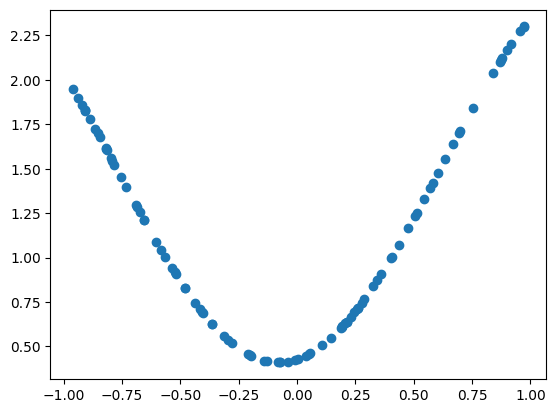

In [113]:
batch = dataloader.dataset[5]
x, y = batch[0], batch[1]
print(np.array(batch).shape)
print(x.shape)
print(y.shape)

#below doesn't give the same result
batches = jnp.asarray( jax.tree_util.tree_map(lambda tensor : tensor.numpy(), [batch for batch in dataloader]))
#batches = [jax.tree_util.tree_map(lambda tensor: tensor.numpy(), batch) for batch in dataloader]
print(batches.shape)

batch = batches[0]
x, y = batch[0][0], batch[1][0]
plt.scatter(x, y)

In [230]:
from tqdm import tqdm
save_path = "./baseline_deneme9/"
model_name = "base_0_1_"
os.makedirs(save_path, exist_ok=True)
eval_intervals = 512
eval_dataset_size = 1000

model, params = create_model(key)
optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params

training_steps = 0
losses = []
best = float('inf')
best_params = None
eval_params = {"eval_point_model_params": []}
in_task_errors = {'ece': [], 'rmse': []}
out_task_errors = []
total_training_samples = 64000

def perform_evaluation(params_new, eval_epoch_key):
    eval_epoch_key, eval_inkey_data, eval_outkey_data, eval_model_key = jax.random.split(eval_epoch_key, 4)
    intask_x_eval, intask_y_eval = generate_noisy_split_trainingdata(samplers, ratios, eval_dataset_size, chunk_size, eval_inkey_data)
    intask_x_eval, intask_y_eval = intask_x_eval[..., None], intask_y_eval[..., None]

    x_contexts, x_targets = jnp.split(intask_x_eval, indices_or_sections=(num_context_samples,), axis=1)
    y_contexts, y_targets = jnp.split(intask_y_eval, indices_or_sections=(num_context_samples,), axis=1)

    ece_errors = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params_new, k=num_posterior_mc), in_axes=(0, 0, 0, 0, 0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
    rmse_errors = nk.jax.vmap_chunked(partial(RMSE_means, model, params_new, k=num_posterior_mc), in_axes=(0, 0, 0, 0, 0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))

    in_task_errors['ece'].append((ece_errors.mean(), ece_errors.std() / np.sqrt(ece_errors.shape[0])))
    in_task_errors['rmse'].append((rmse_errors.mean(), rmse_errors.std() / np.sqrt(rmse_errors.shape[0])))
    eval_params["eval_point_model_params"].append(params_new)

pbar = tqdm(total=total_training_samples, desc='Training Progress')
train_till_eval = 0
while training_steps < total_training_samples:
    rng, key = jax.random.split(rng)
    _, eval_epoch_key = jax.random.split(rng)

    for batch in dataloader:
        if training_steps >= total_training_samples:
            print("bitti")
            break

        batcha = jnp.asarray(jax.tree_util.tree_map(lambda tensor: tensor.numpy(), [batch]))

        if (train_till_eval >= eval_intervals) and (training_steps != 0):
            perform_evaluation(params, eval_epoch_key)
            train_till_eval %= eval_intervals

        params, opt_state, loss_arr = scan_train(params, opt_state, key, batcha)
        training_steps += len(batch[0])
        train_till_eval += len(batch[0])
        losses.extend(loss_arr)

        if loss_arr.min() < best:
            best = loss_arr.min()
            best_params = params

        if jnp.isnan(loss_arr).any():
            break

        pbar.update(len(batch[0]))
        pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

save_model_params(best_params, save_path, model_name)
with open(os.path.join(save_path, model_name + '_eval_point_params.pkl'), 'wb') as f:
    pickle.dump(eval_params, f)
with open(os.path.join(save_path, model_name + '_training_metrics.pkl'), 'wb') as f:
    pickle.dump({"training_loss": losses, "training_intask_errors": in_task_errors, "training_outtask_errors": out_task_errors}, f)

pbar.close()


Optimizing params. Loss: 3.6155:  26%|██▋       | 8448/32000 [01:27<04:02, 96.94it/s] 


bitti


Optimizing params. Loss: 3.6812: 100%|██████████| 32000/32000 [05:05<00:00, 104.73it/s]


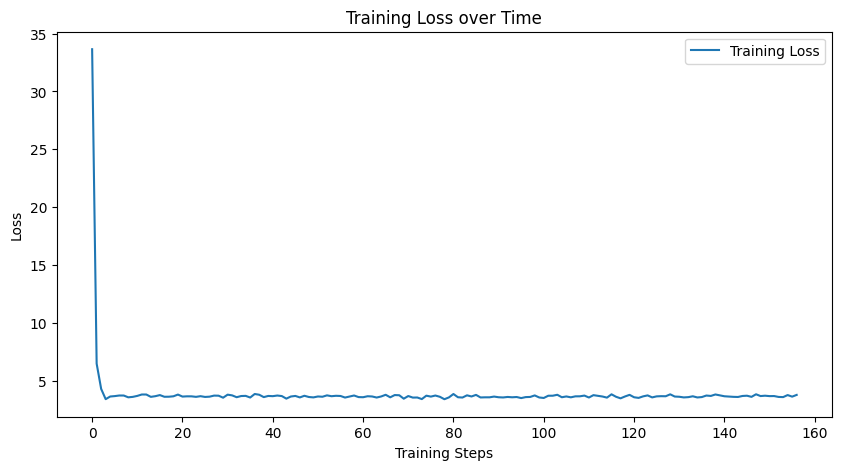

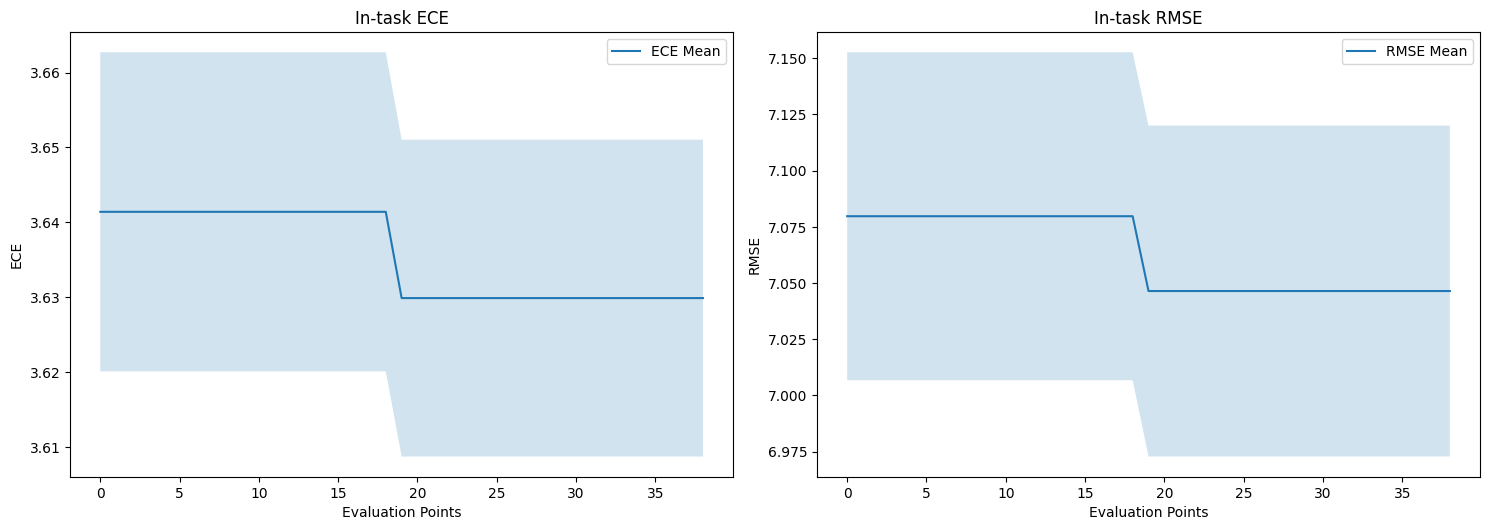

157
[Array(33.64909078, dtype=float64), Array(6.48876705, dtype=float64), Array(4.30532976, dtype=float64), Array(3.41944286, dtype=float64), Array(3.64841137, dtype=float64), Array(3.68263788, dtype=float64), Array(3.73437163, dtype=float64), Array(3.73327665, dtype=float64), Array(3.57868692, dtype=float64), Array(3.61635506, dtype=float64), Array(3.70097369, dtype=float64), Array(3.82200336, dtype=float64), Array(3.8200962, dtype=float64), Array(3.61794354, dtype=float64), Array(3.67680982, dtype=float64), Array(3.77102416, dtype=float64), Array(3.62568134, dtype=float64), Array(3.63095854, dtype=float64), Array(3.66638465, dtype=float64), Array(3.81580398, dtype=float64), Array(3.64186928, dtype=float64), Array(3.66407256, dtype=float64), Array(3.66225131, dtype=float64), Array(3.6186685, dtype=float64), Array(3.67633701, dtype=float64), Array(3.61129999, dtype=float64), Array(3.63462115, dtype=float64), Array(3.72643914, dtype=float64), Array(3.71905382, dtype=float64), Array(3.54

In [228]:
import pickle
import os
import matplotlib.pyplot as plt

# Define the path where the data is saved
save_path = "./baseline_deneme8/"
model_name = "base_0_1_"

# Load the saved metrics
with open(os.path.join(save_path, model_name + '_training_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)

# Extract the data
losses = metrics["training_loss"]
in_task_errors = metrics["training_intask_errors"]
out_task_errors = metrics["training_outtask_errors"]

# Function to plot the losses
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss over Time')
    plt.legend()
    plt.show()

# Function to plot in-task errors
def plot_in_task_errors(errors):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot([x[0] for x in errors['ece']], label='ECE Mean')
    plt.fill_between(range(len(errors['ece'])), 
                     [x[0] - x[1] for x in errors['ece']], 
                     [x[0] + x[1] for x in errors['ece']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('ECE')
    plt.title('In-task ECE')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot([x[0] for x in errors['rmse']], label='RMSE Mean')
    plt.fill_between(range(len(errors['rmse'])), 
                     [x[0] - x[1] for x in errors['rmse']], 
                     [x[0] + x[1] for x in errors['rmse']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('RMSE')
    plt.title('In-task RMSE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Function to plot out-task errors (if applicable)
def plot_out_task_errors(errors):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot([x[0] for x in errors['ece']], label='ECE Mean')
    plt.fill_between(range(len(errors['ece'])), 
                     [x[0] - x[1] for x in errors['ece']], 
                     [x[0] + x[1] for x in errors['ece']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('ECE')
    plt.title('Out-task ECE')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot([x[0] for x in errors['rmse']], label='RMSE Mean')
    plt.fill_between(range(len(errors['rmse'])), 
                     [x[0] - x[1] for x in errors['rmse']], 
                     [x[0] + x[1] for x in errors['rmse']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('RMSE')
    plt.title('Out-task RMSE')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot([x[0] for x in errors['ece_noise']], label='ECE Noise Mean')
    plt.fill_between(range(len(errors['ece_noise'])), 
                     [x[0] - x[1] for x in errors['ece_noise']], 
                     [x[0] + x[1] for x in errors['ece_noise']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('ECE Noise')
    plt.title('Out-task ECE Noise')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot([x[0] for x in errors['rmse_noise']], label='RMSE Noise Mean')
    plt.fill_between(range(len(errors['rmse_noise'])), 
                     [x[0] - x[1] for x in errors['rmse_noise']], 
                     [x[0] + x[1] for x in errors['rmse_noise']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('RMSE Noise')
    plt.title('Out-task RMSE Noise')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the losses
plot_losses(losses)

# Plot the in-task errors
plot_in_task_errors(in_task_errors)
print(len(losses))
print(losses)

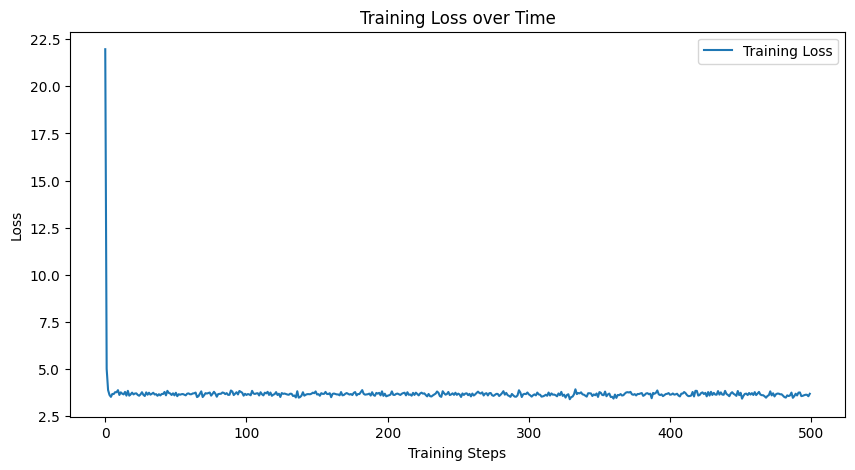

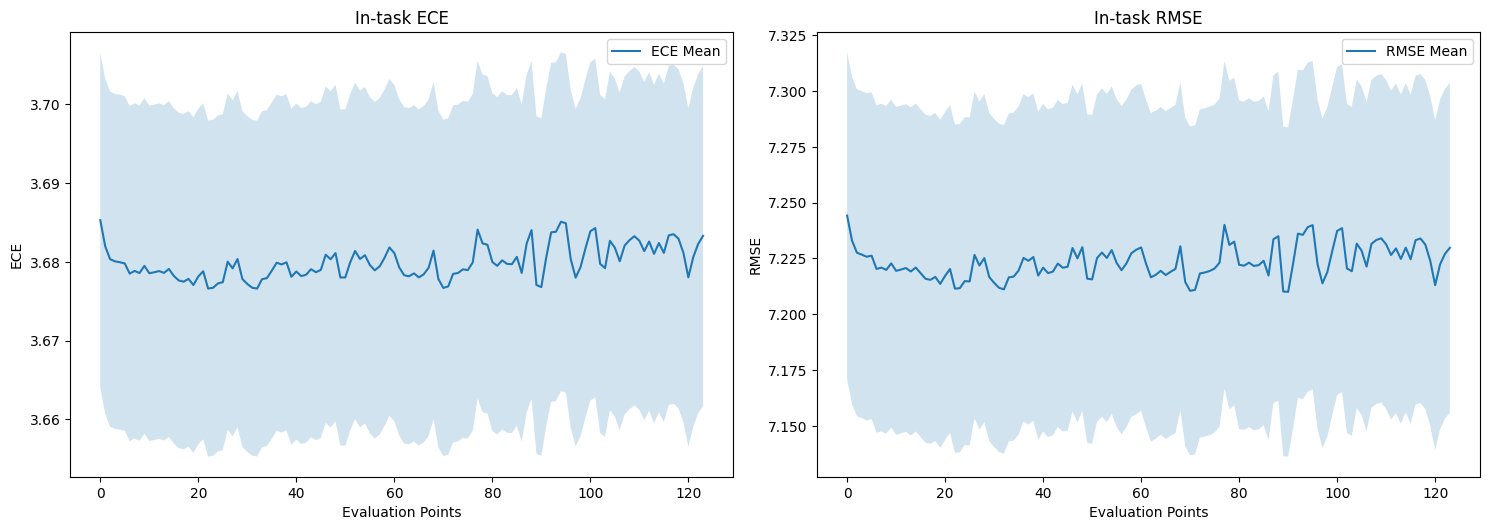

500
[Array(21.96973952, dtype=float64), Array(5.00394449, dtype=float64), Array(3.87783872, dtype=float64), Array(3.61976664, dtype=float64), Array(3.51738676, dtype=float64), Array(3.67083887, dtype=float64), Array(3.66773703, dtype=float64), Array(3.76633727, dtype=float64), Array(3.76370361, dtype=float64), Array(3.87290279, dtype=float64), Array(3.61958829, dtype=float64), Array(3.75858544, dtype=float64), Array(3.68691697, dtype=float64), Array(3.64917541, dtype=float64), Array(3.78040955, dtype=float64), Array(3.58319341, dtype=float64), Array(3.83737575, dtype=float64), Array(3.58232573, dtype=float64), Array(3.64912808, dtype=float64), Array(3.74301545, dtype=float64), Array(3.64653, dtype=float64), Array(3.69480738, dtype=float64), Array(3.70320587, dtype=float64), Array(3.62209183, dtype=float64), Array(3.57705694, dtype=float64), Array(3.65199076, dtype=float64), Array(3.76355267, dtype=float64), Array(3.62592724, dtype=float64), Array(3.56255192, dtype=float64), Array(3.755

In [232]:
import pickle
import os
import matplotlib.pyplot as plt

# Define the path where the data is saved
save_path = "./baseline_deneme9/"
model_name = "base_0_1_"

# Load the saved metrics
with open(os.path.join(save_path, model_name + '_training_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)

# Extract the data
losses = metrics["training_loss"]
in_task_errors = metrics["training_intask_errors"]
out_task_errors = metrics["training_outtask_errors"]

# Function to plot the losses
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss over Time')
    plt.legend()
    plt.show()

# Function to plot in-task errors
def plot_in_task_errors(errors):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot([x[0] for x in errors['ece']], label='ECE Mean')
    plt.fill_between(range(len(errors['ece'])), 
                     [x[0] - x[1] for x in errors['ece']], 
                     [x[0] + x[1] for x in errors['ece']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('ECE')
    plt.title('In-task ECE')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot([x[0] for x in errors['rmse']], label='RMSE Mean')
    plt.fill_between(range(len(errors['rmse'])), 
                     [x[0] - x[1] for x in errors['rmse']], 
                     [x[0] + x[1] for x in errors['rmse']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('RMSE')
    plt.title('In-task RMSE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Function to plot out-task errors (if applicable)
def plot_out_task_errors(errors):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot([x[0] for x in errors['ece']], label='ECE Mean')
    plt.fill_between(range(len(errors['ece'])), 
                     [x[0] - x[1] for x in errors['ece']], 
                     [x[0] + x[1] for x in errors['ece']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('ECE')
    plt.title('Out-task ECE')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot([x[0] for x in errors['rmse']], label='RMSE Mean')
    plt.fill_between(range(len(errors['rmse'])), 
                     [x[0] - x[1] for x in errors['rmse']], 
                     [x[0] + x[1] for x in errors['rmse']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('RMSE')
    plt.title('Out-task RMSE')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot([x[0] for x in errors['ece_noise']], label='ECE Noise Mean')
    plt.fill_between(range(len(errors['ece_noise'])), 
                     [x[0] - x[1] for x in errors['ece_noise']], 
                     [x[0] + x[1] for x in errors['ece_noise']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('ECE Noise')
    plt.title('Out-task ECE Noise')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot([x[0] for x in errors['rmse_noise']], label='RMSE Noise Mean')
    plt.fill_between(range(len(errors['rmse_noise'])), 
                     [x[0] - x[1] for x in errors['rmse_noise']], 
                     [x[0] + x[1] for x in errors['rmse_noise']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('RMSE Noise')
    plt.title('Out-task RMSE Noise')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the losses
plot_losses(losses)

# Plot the in-task errors
plot_in_task_errors(in_task_errors)
print(len(losses))
print(losses)